In [1]:

# basic packages
import pandas as pd
import numpy as np
import datetime as dt
from pytz import timezone
import urllib
import os
import math
from scipy import stats
from scipy.signal import find_peaks, spectrogram

# packages for visualizations
import matplotlib.dates as mdates
import seaborn as sns

from prophet import Prophet
from prophet.plot import plot_seasonality , plot_weekly, plot_yearly

from matplotlib import pyplot as plt


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
weather = './weather_hourly_darksky.csv'

weather_data=pd.read_csv(weather ,  nrows=1000000)
weather_data = weather_data[['time', 'temperature']]

weather_data

,time,temperature
0,2011-11-11 00:00:00,10.24
1,2011-11-11 01:00:00,9.76
2,2011-11-11 02:00:00,9.46
3,2011-11-11 03:00:00,9.23
4,2011-11-11 04:00:00,9.26
...,...,...
21160,2014-02-15 19:00:00,7.39
21161,2014-02-15 20:00:00,6.56
21162,2014-02-15 21:00:00,6.47
21163,2014-02-15 22:00:00,5.96


In [3]:
file_path = './CC_LCL-FullData_without_stdorToU.csv.gz'

df=pd.read_csv(file_path ,  nrows=10000000)
df


# Assuming your DataFrame is named 'df'
# Convert 'DateTime' column to datetime type if it's not already
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Filter rows based on the condition
df = df[df['DateTime'] >= '2012-12-03']

df

,LCLid,DateTime,KWH/hh (per half hour)
2447,MAC000002,2012-12-03 00:00:00,0.255
2448,MAC000002,2012-12-03 00:30:00,0.207
2449,MAC000002,2012-12-03 01:00:00,0.231
2450,MAC000002,2012-12-03 01:30:00,0.224
2451,MAC000002,2012-12-03 02:00:00,0.178
...,...,...,...
9997822,MAC000325,2013-11-22 22:00:00,0
9997823,MAC000325,2013-11-22 22:30:00,0
9997824,MAC000325,2013-11-22 23:00:00,0
9997825,MAC000325,2013-11-22 23:30:00,0


In [4]:
df['KWH/hh (per half hour) '] = pd.to_numeric(df['KWH/hh (per half hour) '], errors='coerce')

df['KWH/hh (per half hour) '] = df['KWH/hh (per half hour) '].fillna(df['KWH/hh (per half hour) '].mean())

In [5]:
import pandas as pd

# Assuming df is your DataFrame
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Find the minimum date for each LCLid
min_dates = df.groupby('LCLid')['DateTime'].min()

# Create a new DataFrame with a DateTime column containing unique date times
unique_datetimes = pd.DataFrame(df['DateTime'].unique(), columns=['DateTime'])

# Initialize an empty DataFrame to store the final result
average_df = unique_datetimes.copy()

# Iterate through LCLids and merge data
for lclid, min_date in min_dates.items():
    lclid_data = df[df['LCLid'] == lclid].copy()
    lclid_data['TimeDelta'] = (lclid_data['DateTime'] - min_date).dt.total_seconds() / 3600
    lclid_data = lclid_data.drop_duplicates(subset=['DateTime'])  # Drop duplicates
    lclid_data_pivot = lclid_data.pivot(index='DateTime', columns='LCLid', values='KWH/hh (per half hour) ')
    average_df = pd.merge(average_df, lclid_data_pivot, how='left', left_on='DateTime', right_on='DateTime')

# If you want to reset the index and fill NaN values with empty
df = average_df.set_index('DateTime').reset_index().fillna('').rename_axis(None, axis=1)

# Display the result
df


,DateTime,MAC000002,MAC000003,MAC000004,MAC000006,MAC000007,MAC000008,MAC000009,MAC000010,MAC000011,...,MAC000316,MAC000317,MAC000318,MAC000319,MAC000320,MAC000321,MAC000322,MAC000323,MAC000324,MAC000325
0,2012-12-03 00:00:00,0.255,0.112,0.177,0.052,0.091,0.404,0.125,0.325,0.174,...,0.026,0.376,0.089,0.174,0.026,3.145,0.917,0.145,0.011,0.027
1,2012-12-03 00:30:00,0.207,3.175,0.0,0.042,0.096,0.664,0.05,0.319,0.171,...,0.026,0.147,0.073,0.209,1.561,3.119,0.15,0.159,0.011,0.035
2,2012-12-03 01:00:00,0.231,3.131,0.0,0.051,0.059,0.663,0.061,0.197,0.209,...,0.005,0.092,0.502,0.163,1.244,1.52,0.147,0.199,0.011,0.012
3,2012-12-03 01:30:00,0.224,3.282,0.0,0.014,0.034,0.622,0.1,0.199,0.135,...,0.0,0.098,0.439,0.204,0.436,3.081,0.147,0.152,0.011,0.008
4,2012-12-03 02:00:00,0.178,2.321,0.025,0.021,0.082,0.687,0.038,0.223,0.118,...,0.031,0.12,0.304,0.174,0.321,3.18,0.104,0.15,0.011,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21733,2012-12-18 15:15:05,,,,,,,,,,...,,,,,,,,,,
21734,2012-12-18 15:15:06,,,,,,,,,,...,,,,,,,,,,
21735,2012-12-18 15:15:07,,,,,,,,,,...,,,,,,,,,,
21736,2012-12-18 15:15:08,,,,,,,,,,...,0.233364,0.233364,0.233364,0.233364,,,,,,


In [6]:
import numpy as np

# Replace 0 with NaN in the DataFrame
df.replace(0, np.nan, inplace=True)

# Convert all columns (except 'DateTime') to numeric
df.loc[:, df.columns != 'DateTime'] = df.loc[:, df.columns != 'DateTime'].apply(pd.to_numeric, errors='coerce')

# Calculate the average energy consumption ignoring NaN values
df['average_energy_consumption'] = df.drop(columns='DateTime').mean(axis=1)

# Create a new DataFrame with only 'DateTime' and 'average_energy_consumption'
df_final = df[['DateTime', 'average_energy_consumption']]

# Display the result
df_final

,DateTime,average_energy_consumption
0,2012-12-03 00:00:00,0.25061
1,2012-12-03 00:30:00,0.274409
2,2012-12-03 01:00:00,0.248655
3,2012-12-03 01:30:00,0.236212
4,2012-12-03 02:00:00,0.205717
...,...,...
21733,2012-12-18 15:15:05,0.233364
21734,2012-12-18 15:15:06,0.233364
21735,2012-12-18 15:15:07,0.233364
21736,2012-12-18 15:15:08,0.233364


In [7]:
print(df_final.columns)
df_final

Index(['DateTime', 'average_energy_consumption'], dtype='object')


,DateTime,average_energy_consumption
0,2012-12-03 00:00:00,0.25061
1,2012-12-03 00:30:00,0.274409
2,2012-12-03 01:00:00,0.248655
3,2012-12-03 01:30:00,0.236212
4,2012-12-03 02:00:00,0.205717
...,...,...
21733,2012-12-18 15:15:05,0.233364
21734,2012-12-18 15:15:06,0.233364
21735,2012-12-18 15:15:07,0.233364
21736,2012-12-18 15:15:08,0.233364


In [8]:
# Assuming your DataFrame is named df
# If 'DateTime' is currently the index, reset it first
df_final.reset_index(inplace=True)

df_final

,index,DateTime,average_energy_consumption
0,0,2012-12-03 00:00:00,0.25061
1,1,2012-12-03 00:30:00,0.274409
2,2,2012-12-03 01:00:00,0.248655
3,3,2012-12-03 01:30:00,0.236212
4,4,2012-12-03 02:00:00,0.205717
...,...,...,...
21733,21733,2012-12-18 15:15:05,0.233364
21734,21734,2012-12-18 15:15:06,0.233364
21735,21735,2012-12-18 15:15:07,0.233364
21736,21736,2012-12-18 15:15:08,0.233364


In [9]:

# Assuming the first dataframe is called 'energy_data' and the second one is called 'temperature_data'

def merge_temperature_with_energy(df_final, weather_data):
    # Convert 'time' column to datetime format in both dataframes
    df_final['DateTime'] = pd.to_datetime(df_final['DateTime'])
    weather_data['time'] = pd.to_datetime(weather_data['time'])

    # Merge the two dataframes based on datetime
    hourly_with_temp_data = pd.merge(df_final, weather_data, left_on='DateTime', right_on='time', how='inner')

    # Drop the 'time' column as it's no longer needed
    hourly_with_temp_data.drop(columns=['time'], inplace=True)

    return hourly_with_temp_data

# Call the function with your dataframes
hourly_with_temp_data = merge_temperature_with_energy(df_final, weather_data)
print(hourly_with_temp_data)

       index            DateTime average_energy_consumption  temperature
0          0 2012-12-03 00:00:00                    0.25061         2.94
1          2 2012-12-03 01:00:00                   0.248655         3.35
2          4 2012-12-03 02:00:00                   0.205717         3.52
3          6 2012-12-03 03:00:00                   0.182897         4.16
4          8 2012-12-03 04:00:00                   0.183267         5.93
...      ...                 ...                        ...          ...
10842  21689 2014-02-27 21:00:00                   0.377821         5.03
10843  21691 2014-02-27 22:00:00                   0.315199         4.10
10844  21693 2014-02-27 23:00:00                   0.266106         3.93
10845  21695 2014-02-28 00:00:00                   0.258453         3.81
10846  21698 2014-01-15 21:00:00                   0.388622        10.34

[10847 rows x 4 columns]


/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_99209/2712791753.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['DateTime'] = pd.to_datetime(df_final['DateTime'])


In [10]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming hourly_with_temp_data is your DataFrame
# Make sure the 'DateTime' column is set as the index
hourly_with_temp_data['DateTime'] = pd.to_datetime(hourly_with_temp_data['DateTime'])
hourly_with_temp_data.set_index('DateTime', inplace=True)

# Perform Dickey-Fuller test on the 'average_energy_consumption' column
result_energy = adfuller(hourly_with_temp_data['average_energy_consumption'])

# Perform Dickey-Fuller test on the 'temperature' column
result_temperature = adfuller(hourly_with_temp_data['temperature'])

# Print the test statistic and p-value for energy consumption
print('ADF Statistic (Energy Consumption):', result_energy[0])
print('p-value (Energy Consumption):', result_energy[1])

# Print the test statistic and p-value for temperature
print('ADF Statistic (Temperature):', result_temperature[0])
print('p-value (Temperature):', result_temperature[1])



# Extract the critical values from the result object
critical_values = result_energy[4]

# Print the critical values
print('Critical Values (Energy Consumption):')
print('1%:', critical_values['1%'])
print('5%:', critical_values['5%'])
print('10%:', critical_values['10%'])


ADF Statistic (Energy Consumption): -3.222356756431677
p-value (Energy Consumption): 0.01872651021647006
ADF Statistic (Temperature): -3.625417241338587
p-value (Temperature): 0.005293289088763103
Critical Values (Energy Consumption):
1%: -3.4309550183477433
5%: -2.8618073843289915
10%: -2.5669123235434235


In [11]:
print(df_final)


       index            DateTime average_energy_consumption
0          0 2012-12-03 00:00:00                    0.25061
1          1 2012-12-03 00:30:00                   0.274409
2          2 2012-12-03 01:00:00                   0.248655
3          3 2012-12-03 01:30:00                   0.236212
4          4 2012-12-03 02:00:00                   0.205717
...      ...                 ...                        ...
21733  21733 2012-12-18 15:15:05                   0.233364
21734  21734 2012-12-18 15:15:06                   0.233364
21735  21735 2012-12-18 15:15:07                   0.233364
21736  21736 2012-12-18 15:15:08                   0.233364
21737  21737 2012-12-18 15:15:09                   0.233364

[21738 rows x 3 columns]


In [12]:
hourly_with_temp_data

,index,average_energy_consumption,temperature
DateTime,,,
2012-12-03 00:00:00,0,0.25061,2.94
2012-12-03 01:00:00,2,0.248655,3.35
2012-12-03 02:00:00,4,0.205717,3.52
2012-12-03 03:00:00,6,0.182897,4.16
2012-12-03 04:00:00,8,0.183267,5.93
...,...,...,...
2014-02-27 21:00:00,21689,0.377821,5.03
2014-02-27 22:00:00,21691,0.315199,4.10
2014-02-27 23:00:00,21693,0.266106,3.93


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0) MSE=0.006199568248813111


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/states

ARIMA(0, 0, 1) MSE=0.0022861050764473967


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/states

ARIMA(0, 0, 2) MSE=0.0013510075529104696


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0) MSE=0.0009971068915257955


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1) MSE=0.0008721038022146813


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2) MSE=0.0008481215968107756


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 2, 0) MSE=0.0012145147461309598


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 2, 1) MSE=0.0010299584029061812


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 2, 2) MSE=0.0008753249839573275


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0) MSE=0.0009503935883909495


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1) MSE=0.0008128319133505207


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 2) MSE=0.0007776959057793665


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0) MSE=0.0008456777431375228


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1) MSE=0.0008446606582576263


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2) MSE=0.0008417526811777019


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 2, 0) MSE=0.001080640977851953


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/base/model

ARIMA(1, 2, 1) MSE=0.0008488720837374633


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarnin

ARIMA(1, 2, 2) MSE=0.0008478167459069667
ARIMA(2, 0, 0) MSE=0.0007588328137362793


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1) MSE=0.0007402723433685474


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2) MSE=0.0007396152917656974


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/base/model

ARIMA(2, 1, 0) MSE=0.0008442398835331111
ARIMA(2, 1, 1) MSE=0.0008437851110482288


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/base/model

ARIMA(2, 1, 2) MSE=0.0006874514455249017
ARIMA(2, 2, 0) MSE=0.0010487095934016593


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/base/model

ARIMA(2, 2, 1) MSE=0.0008474423744595044
ARIMA(2, 2, 2) MSE=0.0008423829987467547
Best ARIMA(2, 1, 2) MSE=0.0006874514455249017


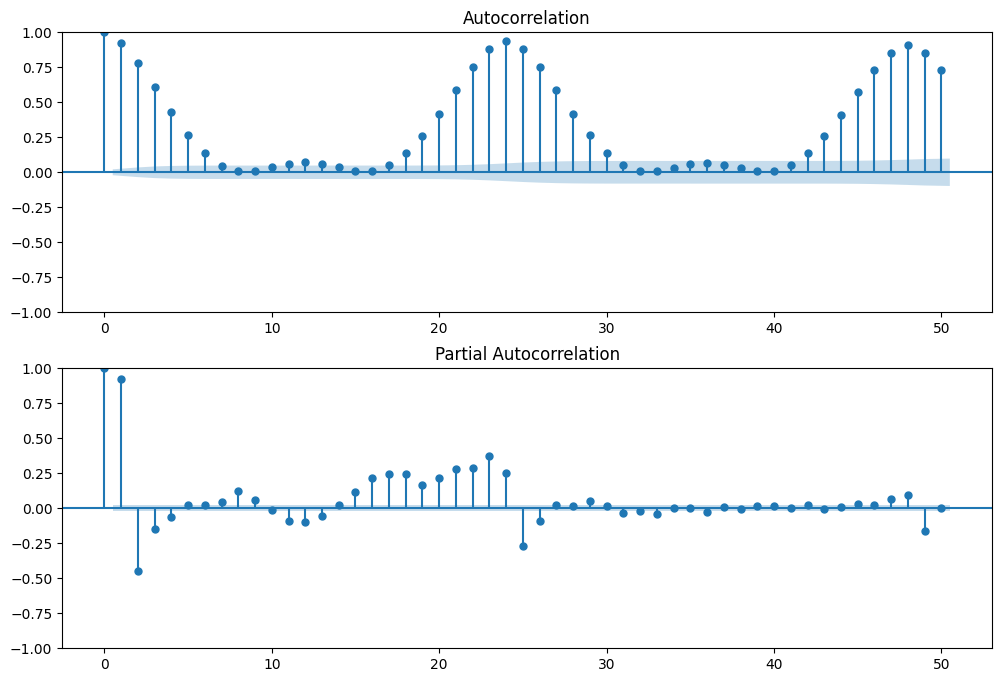

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


hourly_with_temp_data['average_energy_consumption'] = pd.to_numeric(hourly_with_temp_data['average_energy_consumption'], errors='coerce')

# Load the dataset
# Replace 'hourly_with_temp_data' with your DataFrame containing energy consumption data
# Make sure the index is a datetime index
# hourly_with_temp_data.index = pd.to_datetime(hourly_with_temp_data.index)

def arima_grid_search(train_data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train_data, order=order)
                    model_fit = model.fit()
                    if model_fit.mse != float("inf") and model_fit.mse < best_score:
                        best_score, best_cfg = model_fit.mse, order
                    print(f'ARIMA{order} MSE={model_fit.mse}')
                except Exception as e:
                    print(f'Error fitting ARIMA{order}: {e}')
                    continue
    print(f'Best ARIMA{best_cfg} MSE={best_score}')
    return best_cfg


# Replace 'hourly_with_temp_data' with your DataFrame
# Split data into training and testing sets
train_size = int(len(hourly_with_temp_data) * 0.8)
train_data, test_data = hourly_with_temp_data[:train_size], hourly_with_temp_data[train_size:]

# Grid search for ARIMA parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
best_cfg = arima_grid_search(train_data['average_energy_consumption'], p_values, d_values, q_values)

# Plot ACF and PACF to identify seasonality
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_data['average_energy_consumption'], lags=50, ax=ax[0])
plot_pacf(train_data['average_energy_consumption'], lags=50, ax=ax[1])
plt.show()


In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Assuming hourly_with_temp_data is your DataFrame with energy consumption data
# Make sure the index is a datetime index
hourly_with_temp_data.index = pd.to_datetime(hourly_with_temp_data['DateTime'])

# Split data into training and testing sets
train_size = int(len(hourly_with_temp_data) * 0.8)
train_data, test_data = hourly_with_temp_data[:train_size], hourly_with_temp_data[train_size:]

# Convert 'average_energy_consumption' column to float type
train_data['average_energy_consumption'] = train_data['average_energy_consumption'].astype(float)

# Train ARIMA model with temperature as exogenous variable
model = ARIMA(train_data['average_energy_consumption'], exog=train_data['temperature'], order=(5, 1, 0))
model_fit = model.fit()

# Make predictions for the same length as test data
forecast_steps = len(test_data)
future_index = pd.date_range(start=test_data.index[-1], periods=forecast_steps, freq='H', tz=test_data.index.tz)
future_predictions = model_fit.forecast(steps=forecast_steps, exog=test_data['temperature'])

# Evaluate predictions
mse = mean_squared_error(test_data['average_energy_consumption'], future_predictions)
print('Mean Squared Error:', mse)

# Plot manually (adjust as needed)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(test_data.index, test_data['average_energy_consumption'], label='Actual Energy Consumption', color='blue')
ax1.plot(future_index[:len(test_data)], future_predictions[:len(test_data)], label='Predicted Energy Consumption (Future)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy Consumption')
ax1.set_title('Actual vs. Predicted Energy Consumption (One-Year Projection) with Temperature as Exogenous Variable')
ax1.legend()
plt.show()


KeyError: 'DateTime'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose


# Assuming hourly_with_temp_data is your DataFrame with energy consumption data
# Make sure the index is a datetime index
if 'DateTime' in hourly_with_temp_data.columns:
    hourly_with_temp_data['DateTime'] = pd.to_datetime(hourly_with_temp_data['DateTime'])
    hourly_with_temp_data.set_index('DateTime', inplace=True)
else:
    print("Error: 'DateTime' column not found in the DataFrame.")


# Split data into training and testing sets
train_size = int(len(hourly_with_temp_data) * 0.8)
train_data, test_data = hourly_with_temp_data[:train_size], hourly_with_temp_data[train_size:]

# Convert 'average_energy_consumption' column to float type
train_data['average_energy_consumption'] = train_data['average_energy_consumption'].astype(float)

# Decompose time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(train_data['average_energy_consumption'], period=24)  # Assuming daily seasonality
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Train ARIMA models for each component
trend_model = ARIMA(trend.dropna(), order=(5, 1, 0))
trend_model_fit = trend_model.fit()

seasonal_model = ARIMA(seasonal.dropna(), order=(5, 1, 0))
seasonal_model_fit = seasonal_model.fit()

residual_model = ARIMA(residual.dropna(), order=(5, 1, 0))
residual_model_fit = residual_model.fit()

# Forecast each component into the future
forecast_steps = len(test_data)
future_index = pd.date_range(start=test_data.index[0], periods=forecast_steps, freq='H', tz=test_data.index.tz)

trend_forecast = trend_model_fit.forecast(steps=forecast_steps)
seasonal_forecast = seasonal_model_fit.forecast(steps=forecast_steps)
residual_forecast = residual_model_fit.forecast(steps=forecast_steps)

# Combine forecasts
overall_forecast = trend_forecast + seasonal_forecast + residual_forecast

# Evaluate predictions
mse = mean_squared_error(test_data['average_energy_consumption'], overall_forecast)
print('Mean Squared Error:', mse)

# Plot manually (adjust as needed)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(test_data.index, test_data['average_energy_consumption'], label='Actual Energy Consumption', color='blue')
ax1.plot(future_index, overall_forecast, label='Predicted Energy Consumption (Future)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy Consumption')
ax1.set_title('Actual vs. Predicted Energy Consumption (One-Year Projection) with Seasonality')
ax1.legend()
plt.show()


Error: 'DateTime' column not found in the DataFrame.


/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_98976/758329338.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['average_energy_consumption'] = train_data['average_energy_consumption'].astype(float)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

ValueError: Found input variables with inconsistent numbers of samples: [2170, 2194]

In [ ]:

# 1. Fit the ARIMA model
# Assuming you have already trained the ARIMA model and stored it in `model_fit`

# 2. Extract model parameters
# Assuming you have a model with exogenous variables where temperature is included
# You can access the coefficients using `model_fit.params`
coefficients = model_fit.params

# 3. Interpretation
# Calculate the average energy consumption over the entire training dataset
baseline_energy_consumption = np.mean(train_data['average_energy_consumption'])

# Extract the coefficient for temperature from the model parameters
coefficient_temperature = coefficients['temperature']

# Print the results
print("Intercept (Baseline Energy Consumption):", baseline_energy_consumption)
print("Coefficient for Temperature:", coefficient_temperature)


KeyError: 'temperature'

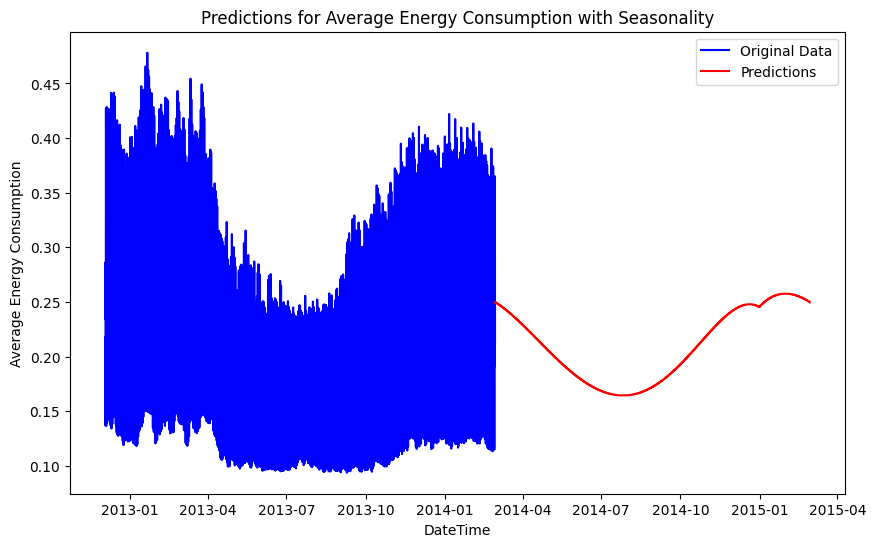

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Sort the dataset by DateTime
df_final_sorted = df_final.sort_values(by='DateTime')

# Extract day of the year as a feature
df_final_sorted['DayOfYear'] = df_final_sorted['DateTime'].dt.dayofyear

# Assuming df_final is your DataFrame containing the dataset
last_timestamp = df_final_sorted['DateTime'].max()

# Add one month to the last timestamp
one_month_later = last_timestamp + pd.DateOffset(months=12)

# Generate future timestamps at half-hour intervals for the entire month
future_timestamps = pd.date_range(last_timestamp, one_month_later, freq='30T')

# Convert future timestamps to integer timestamps in seconds
X_future_int = (future_timestamps - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Define polynomial degree for the seasonal pattern
degree = 6  # You may need to adjust this based on the complexity of the seasonal patterns

# Prepare polynomial features for day of the year
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(df_final_sorted['DayOfYear'].values.reshape(-1, 1))

# Fit linear regression model
model = LinearRegression()
model.fit(X_poly, df_final_sorted['average_energy_consumption'])

# Prepare polynomial features for future timestamps
X_future_poly = poly.transform(future_timestamps.dayofyear.values.reshape(-1, 1))

# Perform prediction
y_pred = model.predict(X_future_poly)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(df_final_sorted['DateTime'], df_final_sorted['average_energy_consumption'], label='Original Data', color='blue')

# Plot the predictions
plt.plot(future_timestamps, y_pred, label='Predictions', color='red')

# Add labels and title
plt.xlabel('DateTime')
plt.ylabel('Average Energy Consumption')
plt.title('Predictions for Average Energy Consumption with Seasonality')
plt.legend()

# Show plot
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Calculate R-squared value
r2 = r2_score(df_final_sorted['average_energy_consumption'], model.predict(X_poly))

print('R-squared value:', r2)

R-squared value: 0.18898841945165956


In [ ]:
from sklearn.metrics import mean_squared_error

# Perform prediction for the sorted dataset
y_pred_sorted = model.predict(X_poly)

# Calculate the Mean Squared Error
mse = mean_squared_error(df_final_sorted['average_energy_consumption'], y_pred_sorted)

# Print the Mean Squared Error
print("Mean Squared Error:", mse)


Mean Squared Error: 0.005388194112588995


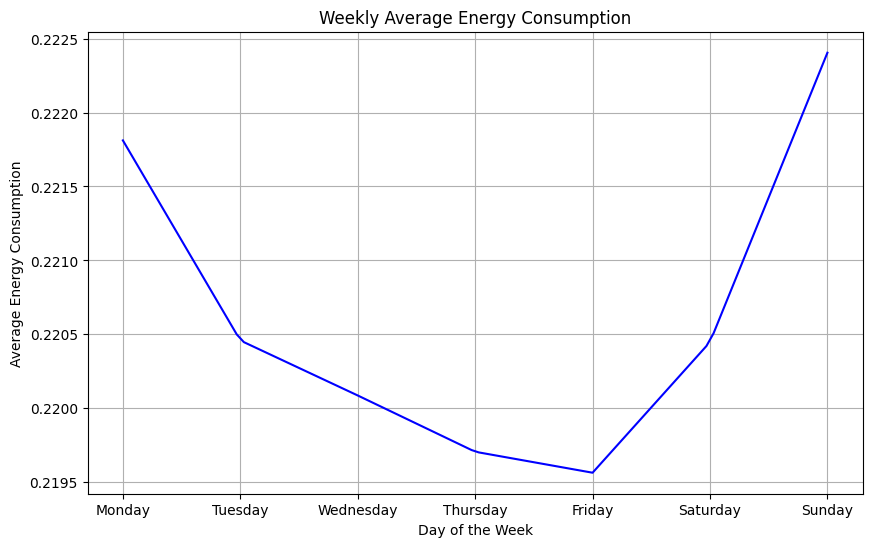

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sort the dataset by DateTime
df_final_sorted = df_final.sort_values(by='DateTime')

# Extract day of the week as a feature
df_final_sorted['DayOfWeek'] = df_final_sorted['DateTime'].dt.dayofweek

# Calculate average energy consumption for each day of the week
weekly_avg_consumption = df_final_sorted.groupby('DayOfWeek')['average_energy_consumption'].mean()

# Smooth the data using a moving average with a larger window size
window_size = 7  # Adjust the window size as needed
weekly_avg_consumption_smoothed = weekly_avg_consumption.rolling(window=window_size, min_periods=1).mean()

# Interpolate to generate a smoother curve
days_of_week = np.arange(7)
smoothed_interpolated = np.interp(np.linspace(0, 6, 100), days_of_week, weekly_avg_consumption_smoothed)

# Define the days of the week
days_of_week_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the smoothed and interpolated weekly average energy consumption
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 6, 100), smoothed_interpolated, marker='', linestyle='-', color='blue')

# Add labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Average Energy Consumption')
plt.title('Weekly Average Energy Consumption')
plt.xticks(np.linspace(0, 6, 7), days_of_week_labels)  # Set x-axis ticks to show days of the week
plt.grid(True)
plt.show()


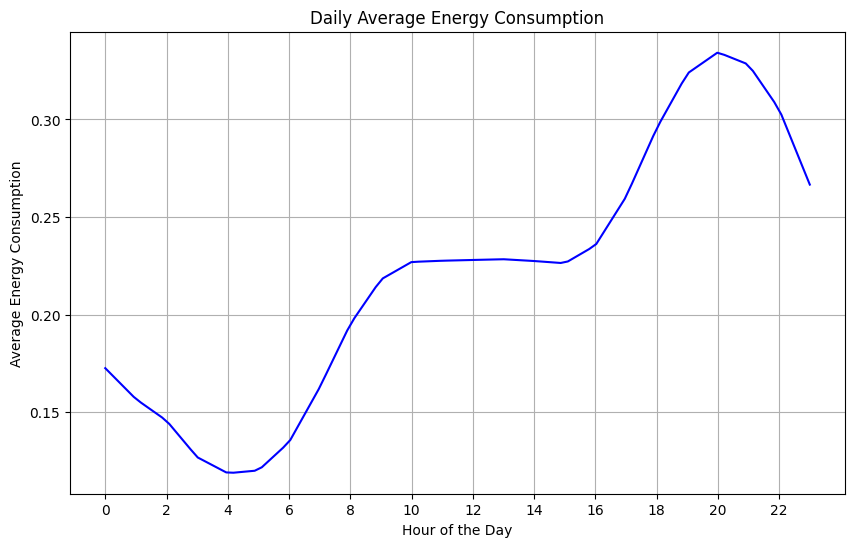

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sort the dataset by DateTime
df_final_sorted = df_final.sort_values(by='DateTime')

# Extract hour of the day as a feature
df_final_sorted['HourOfDay'] = df_final_sorted['DateTime'].dt.hour

# Calculate average energy consumption for each hour of the day
daily_avg_consumption = df_final_sorted.groupby('HourOfDay')['average_energy_consumption'].mean()

# Smooth the data using a moving average with a larger window size
window_size = 3  # Adjust the window size as needed
daily_avg_consumption_smoothed = daily_avg_consumption.rolling(window=window_size, min_periods=1).mean()

# Interpolate to generate a smoother curve
hours_of_day = np.arange(24)
smoothed_interpolated = np.interp(np.linspace(0, 23, 100), hours_of_day, daily_avg_consumption_smoothed)

# Plot the smoothed and interpolated daily average energy consumption
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 23, 100), smoothed_interpolated, marker='', linestyle='-', color='blue')

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Consumption')
plt.title('Daily Average Energy Consumption')
plt.xticks(np.arange(0, 24, 2))  # Set x-axis ticks to show every 2 hours
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'Timestamp' is your timestamp and 'average_energy_consumption' is the energy consumption
X = df_final[['DateTime']]
y = df_final['average_energy_consumption']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Creating DataFrames for train and test sets
train_data = pd.DataFrame({'ds': X_train['DateTime'], 'y': y_train, 'LCLid': None})
test_data = pd.DataFrame({'ds': X_test['DateTime'], 'y': y_test, 'LCLid': None})

# Printing the shapes of the resulting sets
print("Training set shapes - X_train:", X_train.shape, "y_train:", y_train.shape)
print("Testing set shapes - X_test:", X_test.shape, "y_test:", y_test.shape)


train_data

Training set shapes - X_train: (17776, 1) y_train: (17776,)
Testing set shapes - X_test: (4444, 1) y_test: (4444,)


,ds,y,LCLid
11262,2013-07-25 15:00:00,0.175859,None
14797,2013-10-07 06:30:00,0.196115,None
7278,2013-05-03 15:00:00,0.166012,None
18796,2013-12-29 14:00:00,0.297024,None
9237,2013-06-13 10:30:00,0.188589,None
...,...,...,...
11964,2013-08-09 06:00:00,0.143725,None
21575,2014-02-25 12:00:00,0.20935,None
5390,2013-03-25 07:00:00,0.223931,None
860,2012-12-20 22:00:00,0.335754,None


In [ ]:
print("Training set timestamps - Min:", train_data['ds'].min(), "Max:", train_data['ds'].max())
print("Testing set timestamps - Min:", test_data['ds'].min(), "Max:", test_data['ds'].max())


Training set timestamps - Min: 2012-12-03 00:00:00 Max: 2014-02-28 00:00:00
Testing set timestamps - Min: 2012-12-03 01:30:00 Max: 2014-02-27 16:30:00


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming df_final is your DataFrame with energy consumption data
# Make sure the index is a datetime index
df_final.reset_index(inplace=True)
df_final.set_index('DateTime', inplace=True)

# Split data into training and testing sets
train_size = int(len(df_final) * 0.8)
train_data, test_data = df_final[:train_size], df_final[train_size:]

# Convert 'average_energy_consumption' column to float type
train_data['average_energy_consumption'] = train_data['average_energy_consumption'].astype(float)

# Decompose time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(train_data['average_energy_consumption'], period=24)  # Assuming daily seasonality
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Train ARIMA models for each component
order = (5, 1, 0)  # Initial choice of ARIMA parameters
trend_model = ARIMA(trend.dropna(), order=order)
trend_model_fit = trend_model.fit()

seasonal_model = ARIMA(seasonal.dropna(), order=order)
seasonal_model_fit = seasonal_model.fit()

residual_model = ARIMA(residual.dropna(), order=order)
residual_model_fit = residual_model.fit()

# Forecast each component into the future
forecast_steps = len(test_data)
trend_forecast = trend_model_fit.forecast(steps=forecast_steps)
seasonal_forecast = seasonal_model_fit.forecast(steps=forecast_steps)
residual_forecast = residual_model_fit.forecast(steps=forecast_steps)

# Combine forecasts
overall_forecast = trend_forecast + seasonal_forecast + residual_forecast

# Convert the index of overall_forecast to datetime to match test_data index
overall_forecast.index = pd.to_datetime(overall_forecast.index)

# Pad overall_forecast to match the length of test_data using forward-fill (ffill)
overall_forecast = overall_forecast.reindex(test_data.index, method='ffill')

# Remove NaN values from overall_forecast
overall_forecast_clean = overall_forecast.dropna()

# Remove NaN values from test_data['average_energy_consumption']
test_data_clean = test_data.dropna(subset=['average_energy_consumption'])

# Check if both test_data_clean and overall_forecast_clean are not empty before calculating mean squared error and plotting
if not test_data_clean.empty and not overall_forecast_clean.empty:
    # Calculate mean squared error
    mse = mean_squared_error(test_data_clean['average_energy_consumption'], overall_forecast_clean)
    print('Mean Squared Error:', mse)
    
    # Plot manually (adjust as needed)
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(test_data_clean.index, test_data_clean['average_energy_consumption'], label='Actual Energy Consumption', color='blue')
    ax1.plot(test_data_clean.index, overall_forecast_clean, label='Predicted Energy Consumption (Future)', color='orange')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Energy Consumption')
    ax1.set_title('Actual vs. Predicted Energy Consumption (One-Year Projection) with Seasonality')
    ax1.legend()
    plt.show()
else:
    print("Error: Unable to calculate mean squared error or plot data. Check if test data and forecasts are empty.")


/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_86333/356832140.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['average_energy_consumption'] = train_data['average_energy_consumption'].astype(float)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Error: Unable to calculate mean squared error or plot data. Check if test data and forecasts are empty.


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
df_final

NameError: name 'df_final' is not defined

Error: 'DateTime' column not found in the DataFrame.


/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_86333/1072093788.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['average_energy_consumption'] = train_data['average_energy_consumption'].astype(float)
/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_86333/1072093788.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['average_energy_consumption'] = test_data['average_energy_consumption'].astype(float)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/li

Mean Squared Error: 0.006304236840214212


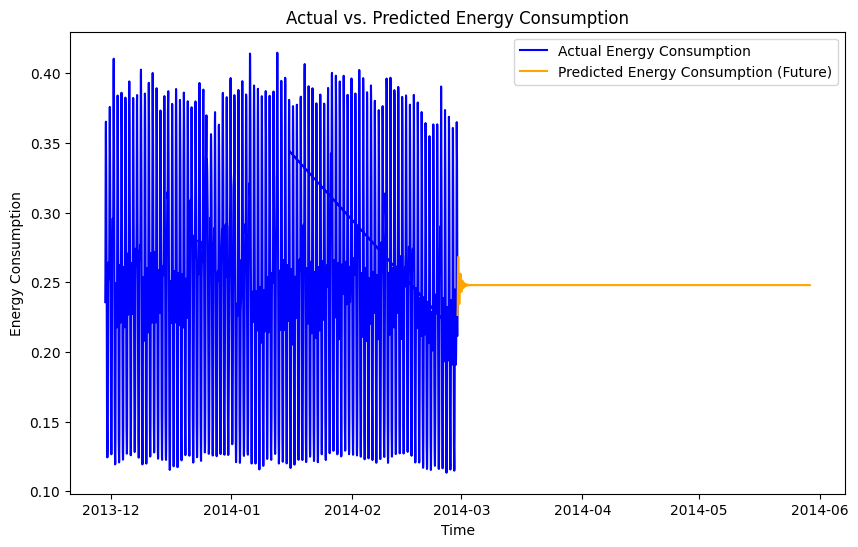

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Assuming hourly_with_temp_data is your DataFrame with energy consumption data
# Make sure the index is a datetime index
if 'DateTime' in hourly_with_temp_data.columns:
    hourly_with_temp_data['DateTime'] = pd.to_datetime(hourly_with_temp_data['DateTime'])
    hourly_with_temp_data.set_index('DateTime', inplace=True)
else:
    print("Error: 'DateTime' column not found in the DataFrame.")

# Split data into training and testing sets
train_size = int(len(hourly_with_temp_data) * 0.8)
train_data, test_data = hourly_with_temp_data[:train_size], hourly_with_temp_data[train_size:]

# Convert 'average_energy_consumption' column to float type
train_data['average_energy_consumption'] = train_data['average_energy_consumption'].astype(float)
test_data['average_energy_consumption'] = test_data['average_energy_consumption'].astype(float)

# Train ARIMA model with temperature as exogenous variable
model = ARIMA(train_data['average_energy_consumption'], exog=train_data['temperature'], order=(10, 1, 0))
model_fit = model.fit()

# Make predictions starting from 2014-03
start_time = pd.Timestamp('2014-02-28')  # Start time for the predictions
future_index = pd.date_range(start=start_time, periods=len(test_data), freq='H', tz=test_data.index.tz)
future_exog = pd.Series([test_data['temperature'].iloc[-1]] * len(test_data), index=future_index)  # Repeat the last temperature value for the forecast period
future_predictions = model_fit.forecast(steps=len(test_data), exog=future_exog.values.reshape(-1, 1))

# Evaluate predictions
mse = mean_squared_error(test_data['average_energy_consumption'], future_predictions)
print('Mean Squared Error:', mse)

# Plot manually (adjust as needed)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(test_data.index, test_data['average_energy_consumption'], label='Actual Energy Consumption', color='blue')
ax1.plot(future_index, future_predictions, label='Predicted Energy Consumption (Future)', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy Consumption')
ax1.set_title('Actual vs. Predicted Energy Consumption')
ax1.legend()
plt.show()


Error: 'DateTime' column not found in the DataFrame.


/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_98976/1791846437.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['average_energy_consumption'] = train_data['average_energy_consumption'].astype(float)
/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_98976/1791846437.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['average_energy_consumption'] = test_data['average_energy_consumption'].astype(float)
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/li